In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%pip install langchain

In [ ]:
%pip install pdfminer.six

In [ ]:
%pip install tiktoken

In [ ]:
%pip install sentence_transformers

In [ ]:

%pip install openai

## For Data crawled by me

In [ ]:
# Enter path of source documents
source_directory = "/content/drive/MyDrive/daiict_webCrawl self data with chromadb private gpt/web crawl_DAIICT/docs/daiict.ac.in"

In [ ]:
import os
import pandas as pd
import re
from langchain.document_loaders import PDFMinerLoader
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [ ]:

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir(source_directory):
    print("Processing files: " + file)
    # Open the file and read the text
    if file[-3:]=="txt":
      with open(f"{source_directory}"+ "/" + file, "r",encoding="UTF-8") as f:
          text = f.read()
          # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
          texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))
    elif file[-3:]=='pdf':
      loader = PDFMinerLoader(f"{source_directory}"+ "/" + file)
      result = loader.load()
      text = result[0].page_content
      texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

Processing files: daiict.ac.in_publication.txt
Processing files: daiict.ac.in_.txt
Processing files: daiict.ac.in_da_iict_extends_its_record_excellent_placements_google_opens_drive_first_time.txt
Processing files: daiict.ac.in_index.php_placement_news_updates.txt
Processing files: daiict.ac.in_index.php_dean_students.txt
Processing files: daiict.ac.in_index.php_screen_reader_access.txt
Processing files: daiict.ac.in_copyright_policy.txt
Processing files: daiict.ac.in_index.php_associate_dean_academic_programs.txt
Processing files: daiict.ac.in_index.php_staff_positions.txt
Processing files: daiict.ac.in_index.php_project_positions.txt
Processing files: daiict.ac.in_research_groups_0.txt
Processing files: daiict.ac.in_old_positions.txt
Processing files: daiict.ac.in_gpu_education_center_da_iict.txt
Processing files: daiict.ac.in_current_position_page_1.txt
Processing files: daiict.ac.in_current_position.txt
Processing files: daiict.ac.in_node.txt
Processing files: daiict.ac.in_node_2702

In [ ]:
#create dataframe
df = pd.DataFrame(texts, columns = ['fname', 'text'])

In [ ]:
# Raw dataframe without text cleaning
df.head()

,fname,text
0,n publication,\n \n \n \n \n \n \n \n \n \n \n \n Publicatio...
1,n,\n \n \n \n \n \n \n \n \n \n \n \n Home | Dhi...
2,n da iict extends its record excellent placeme...,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n D...
3,n index.php placement news updates,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n P...
4,n index.php dean students,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n I...


In [ ]:
# Data cleaning by using remove_newlines function
df['text'] = df.fname + ". " + remove_newlines(df.text)

<ipython-input-11-72a9d6dcbe7c>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


In [ ]:
df.head()

,fname,text
0,n publication,n publication. Publications | Dhirubhai ...
1,n,n . Home | Dhirubhai Ambani Institute of...
2,n da iict extends its record excellent placeme...,n da iict extends its record excellent placeme...
3,n index.php placement news updates,n index.php placement news updates. Pl...
4,n index.php dean students,n index.php dean students. I/c Dean St...


In [ ]:
# Further remove extra whitespaces from the text
for index, row in df.iterrows():
  row['text'] = re.sub(r"\s+", " ", row['text'])

In [ ]:
df['text'][0]

'n publication. Publications | Dhirubhai Ambani Institute of Information and Communication Technology displayNone displayNone Accessibility Menu Contrast View Text Resize Skip to Main Content Screen Reader Access Pause Animations Pause Cursor PG Admissions 2023 Announced | Ph.D. Admissions 2023 Announced | Admission Helpline - Voice call: 080 66 91 91 80 M.Tech. (EC) - last date 28 th April 2022 Admission Helpline - Voice call: 080 66 91 91 80 Top Right Side Menu DCEI CEP NAAC NIRF Parents Alumni GR Cell ICC Policies Newsletter Gallery Directory Contact Location logo Dhirubhai Ambani Institute of Information and Communication Technology A Private University Established by The State Government of Gujarat Act search search Search Daiict Menu About Us Governance Founder President Board of Governors Director Executive Registrar Academic Council Dean (Academics) Dean (Academic Programs) Associate Dean (Academic Programs) Dean (Research) Dean (R&D) Associate Dean (R&D) Dean Students Finance 

<Axes: >

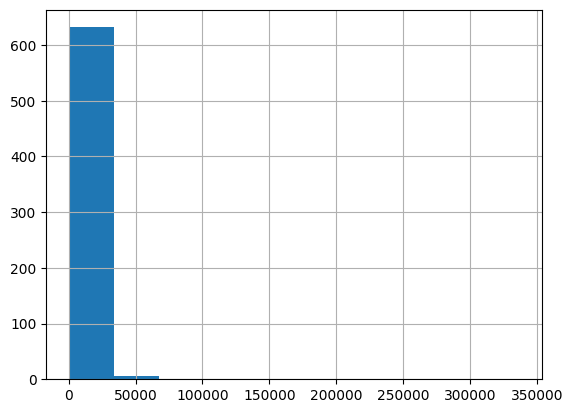

In [ ]:
import tiktoken

# load tiktoken text splitter
tokenizer = tiktoken.get_encoding("cl100k_base")

df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [ ]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    # Add the last chunk to the list of chunks
    if chunk:
        chunks.append(". ".join(chunk) + ".")

    return chunks


shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])

    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<Axes: >

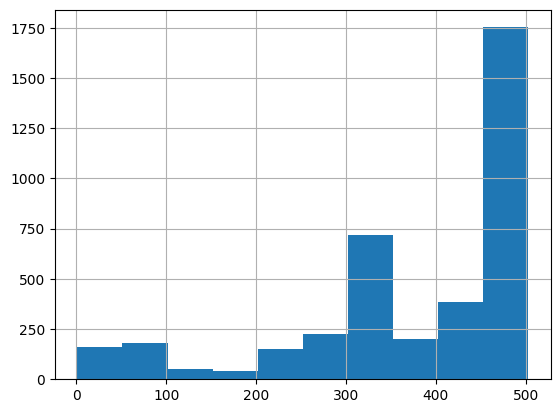

In [ ]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()


In [ ]:
df['text'][46]

'Last date for application Knowledge Compilation in Modal and Multimodal Logic Junior Research Fellow (JRF) 1 03-07-2016 Contact: Prof. Manoj Raut (manoj[dot]raut[at]gmail[dot]com) Name of the Project Name of the Position No. Last date for application Kinetic Modeling of Large size Negative Ion Sources for Fusion Application using Emerging Parallel Processing Computer Architectures. Junior Research Fellow (JRF) 1 10-02-2016 Contact: Dr. Bhaskar Chaudhury (bhaskar_chaudhury[at]daiict[dot]ac[dot]in) Name of the Project Name of the Position No. Last date for application NIF Sponsored “Value Addition in the Grassroot Technologies” Research Engineer 1 15-09-2015 Contact: Dr. Anil K. Roy (anil_roy[at]daiict[dot]ac[dot]in) Name of the Project Name of the Position No. Last date for application Cross Lingual Information Access (CLIA) Project Personnel Category A 1 04-05-2015 Contact: Prof. Prasenjit Majumder (p_majumder[at]daiict[dot]ac[dot]in) Name of the Project Name of the Position No. Last 

In [ ]:
import numpy as np
from numpy.linalg import norm
from sentence_transformers import SentenceTransformer
# load embeddings model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
# Generate embedding for all text chunks
df['embeddings'] = df.text.apply(lambda x: model.encode(x))

In [ ]:
df.head()

,text,n_tokens,embeddings
0,n publication. Publications | Dhirubhai Ambani...,80,"[-0.07630606, 0.0017959079, 0.03520335, -0.040..."
1,"Heidelberg, Germany: Springer-Verlag, 2020. IS...",445,"[0.028490448, -0.06028102, 0.039448973, 0.0024..."
2,ISBN: 9781139924641 Pagination Current page 1 ...,298,"[-0.03827559, -0.00841916, -0.03153175, -0.006..."
3,Sahasrabudhe - A Memoir displayNone Holidays 2...,303,"[-0.025205627, -0.029433258, -0.021254549, -0...."
4,n . Home | Dhirubhai Ambani Institute of Infor...,486,"[-0.09386169, 0.018516302, 0.005494616, -0.020..."


In [ ]:
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity


def create_context(
    question, df, max_len=500
):
    """
    Function responsible for context retrieval
    """
    # Encode the user query
    q_embeddings = model.encode(question)
    # calculate the cosine similarity with the user query
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    for i, row in df.sort_values('distances', ascending=True).iterrows():

        cur_len += row['n_tokens'] + 4

        if cur_len > max_len:
            break

        returns.append(row["text"])

    return "\n\n###\n\n".join(returns)

In [ ]:
question =  "What is B.Tech curriculum? "

context = create_context(
  question,
  df,
)
context

'n sites default files Annexure II.pdf. BTech (ICT) Curriculum 2016 Summary Report Dhirubhai Ambani Institute of Information and Communication Technology Near Indroda Circle, Gandhinagar, Gujarat, India. 382007 Tel: +91 7930520000 | Fax: +91 7930520010 | Web: www.daiict.ac.in 1 Summary DA-IICT offers a unique four-year undergraduate program leading to the degree of Bachelor of Technology in Information and Communication Technology - BTech(ICT). The pedagogy of ICT discipline should make a well-integration of Information Technology, Communication Technology, Electronics Engineering and Social Sciences courses, which a student cannot be trained in conventional Computer Science and Engineering or Electronics and Communication Engineering alone. The curriculum review process, started in July 2015, went through intensive interactions amongst specialized groups of faculty, formal meetings with faculty at large, discussion with external experts and multiple rounds of brain storming within the

In [ ]:
question =  "What are the placement statistics? "

context = create_context(
  question,
  df,
)
context

'Furthermore, they get to interact and engage with the industry professionals during the placement drives, which further help lay a foundation for their prospective career in the future as they familiarise with potential contacts from their chosen career field. The Placement Cell plays a crucial role in locating job opportunities for Under Graduates and Post Graduates passing out from the institute by being in touch with reputed firms and industrial establishments. The Placement Cell operates round the year to facilitate contacts between companies and graduates. The number of students placed through the campus interviews is continuously rising. We have been successful in maintaining our high placement statistics over the years and the fact that our students bear the recession blues with record breaking placements itself is a testimony to our quality. Our ingenious alumnae have set new standards in the corporate world through their estimable contributions and it is my firm conviction th

In [ ]:
question =  "How is the campus life at DAIICT? "

context = create_context(
  question,
  df,
)
context

''